## 🎯 Objectif du projet
Ce projet a pour objectif de développer un modèle de **Machine Learning** capable de détecter automatiquement les transactions bancaires potentiellement frauduleuses.

Grâce à l’analyse de données historiques de transactions, nous cherchons à :
- Identifier les comportements inhabituels des utilisateurs 🕵️‍♂️  
- Réduire le nombre de fraudes non détectées 💳  
- Minimiser les faux positifs pour ne pas bloquer des clients légitimes ⚖️  

---

## 📊 Contexte
La fraude bancaire représente chaque année des pertes considérables pour les institutions financières.  
Les méthodes traditionnelles basées sur des règles statiques sont souvent insuffisantes face à l’évolution rapide des techniques de fraude.  
C’est pourquoi les banques s’appuient désormais sur des approches **data-driven** et **apprenantes** pour améliorer la détection en temps réel.


In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# classifeir Librairies
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import collections


# other Librairies
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalance_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

## Analyse exploratoire des données (EDA)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


In [ ]:
card_df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
card_df.shape

(284807, 31)

In [ ]:
# Types de données et valeurs manquantes
print(card_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- Time

Nombre de secondes écoulées entre chaque transaction et la première transaction du dataset. Elle représente l’ordre chronologique des opérations, pas l’heure réelle.

- V1 à V28

Ces 28 colonnes proviennent d’une transformation PCA (analyse en composantes principales) des variables d’origine (montant, type de marchands, caractéristiques des clients, etc.). Les données d’origine ont été rendues anonymes pour des raisons de confidentialité.

- Amount

Montant de la transaction en euros.

- Class

0 → transaction normale

1 → transaction frauduleuse

In [ ]:
card_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


📋 Répartition des classes :
Class
0    284315
1       492
Name: count, dtype: int64

📈 Pourcentage des classes :
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


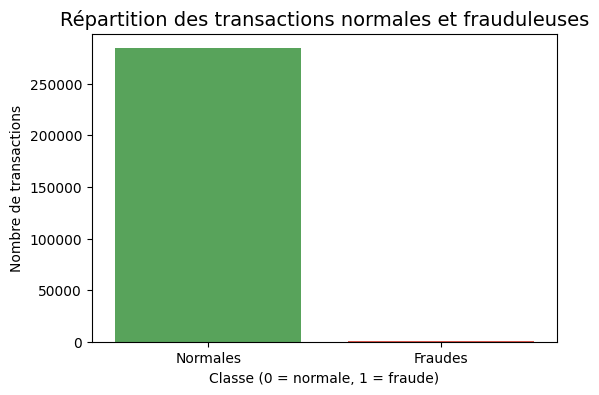

In [ ]:
class_counts = card_df['Class'].value_counts()

# Pourcentage de chaque classe
class_percent = card_df['Class'].value_counts(normalize=True) * 100

# Affichage des résultats
print("📋 Répartition des classes :")
print(class_counts)
print("\n📈 Pourcentage des classes :")
print(class_percent)

# Visualisation graphique
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#4CAF50','#F44336'])
plt.title("Répartition des transactions normales et frauduleuses", fontsize=14)
plt.xlabel("Classe (0 = normale, 1 = fraude)")
plt.ylabel("Nombre de transactions")
plt.xticks([0, 1], ["Normales", "Fraudes"])
plt.show()

La visualisation met clairement en évidence un fort déséquilibre entre les deux classes du jeu de données :

- la grande majorité des transactions sont normales (classe 0),

- tandis que les transactions frauduleuses (classe 1) représentent une proportion très faible du total.

Ce déséquilibre a des conséquences importantes sur la performance des modèles de Machine Learning :

- Un modèle non adapté pourrait simplement prédire toutes les transactions comme “non frauduleuses” et obtenir une très haute accuracy (≈99 %),
→ mais il échouerait à détecter les fraudes réelles.

Il faut donc adapter la stratégie d’apprentissage pour tenir compte de ce déséquilibre, par exemple en :


rééchantillonnant les données (oversampling, undersampling, SMOTE),




Prochaines étapes :

- Mise à l’échelle (scaling) : Les colonnes Amount et Time sont mises à l’échelle afin qu’elles aient des valeurs comparables à celles des autres colonnes.

- Création du sous-échantillon : Le jeu de données contient 492 cas de fraude. Nous allons sélectionner aléatoirement 492 cas de non-fraude afin de créer un nouveau sous-échantillon.

- Concaténation : Les 492 cas de fraude et les 492 cas de non-fraude sont concaténés pour former un nouveau sous-échantillon équilibré.

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less Prone to outliers

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

card_df['scaled_amount'] = rob_scaler.fit_transform(card_df['Amount'].values.reshape(-1,1))
card_df['scaled_time'] = rob_scaler.fit_transform(card_df['Time'].values.reshape(-1,1))

card_df.drop(['Time','Amount'], axis=1, inplace=True)


In [ ]:
scaled_amount = card_df['scaled_amount']
scaled_time = card_df['scaled_time']

card_df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
card_df.insert(0, 'scaled_amount', scaled_amount)
card_df.insert(1, 'scaled_time', scaled_time)


Separation des donnees ( Dataframe Original )

Avant de proceder avec la technique de Random UnderSampling, il est necessaire de separer le DataFrame original. Pour des raisons de test, rappelons-nous que bien que nous separions les donnees lors de la mise en oeuvre des techniques de Random UnderSampling ou OverSampling, nous souhaitons tester nos modeles sur l'ensemble de test cree par l'une de ces techniques. L'objectif principal est d'entrainer le mdele avec les dataframes qui ont ete sous-echantillonnes ou sur-echantillonnes (afin que nos modeles detectent les motifs), puis de le tester sur l;ensemble de test original


In [ ]:
card_df['Class'].value_counts()[0]

np.int64(284315)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import   StratifiedShuffleSplit

print('No Frauds', round(card_df['Class'].value_counts()[0]/len(card_df) * 100,2), '% of the dataset')
print('Frauds', round(card_df['Class'].value_counts()[1]/len(card_df) * 100,2), '% of the dataset')

X = card_df.drop('Class', axis=1)
y = card_df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# we already have X_train and y_train for undersample data thats why
# I am using original to distinguish and to not overwrite these variables.
# original_xtrain, original_xtest, original_ytrain = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the distribution of the labels

# turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distibution: \n')
print(train_counts_label/len(original_ytrain))
print(test_counts_label/len(original_ytest))







No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
Label Distibution: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


### Random Under-Sampling

Dans cette partie, nous allons implementer le "Random Under Sampling", qui consiste essentiellement a supprimer des donnees afin d'obtenir un jeu de donnees plus equilibre et ainsi eviter que nos modeles ne surajustent (overfitting).

- Note:
Le principal inconvenient du "Random Under Sampling" est que nous risquons de perdre beaucoup d'informations, car nous ramenons les 492 transactions non-frauduleuses des 284315 transactions frauduleuses, ce qui peut affecter les performances de nos modeles.



In [ ]:
card_df = card_df.sample(frac=1)

# amount of fraud classes 492 rows.

fraud_df = card_df.loc[card_df['Class'] == 1]
non_fraud_df = card_df.loc[card_df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# shuffle dataframe rows
new_card_df = normal_distributed_df.sample(frac=1, random_state=42)
new_card_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
74253,1.883742,-0.343084,0.858146,-1.288781,0.494446,-1.996879,-1.158328,0.208344,-0.722185,0.316238,...,0.130267,0.341478,0.976559,-0.239873,-0.224682,0.431125,-0.613296,0.103017,0.040255,0
251904,1.017537,0.832505,-1.040067,3.106703,-5.409027,3.109903,-0.887237,-2.497522,-2.073347,0.639818,...,1.054390,0.773961,0.214868,-0.184233,-0.284091,0.493467,0.732329,0.675067,0.337076,1
39032,1.159645,-0.529012,-0.895959,0.438612,1.571733,0.315098,0.017756,0.114066,0.968012,0.274689,...,-0.101558,0.093532,0.110092,0.025611,0.155887,0.156210,-0.502577,0.062248,0.103245,0
261056,0.328513,0.882905,-0.408111,3.132944,-3.098030,5.803893,0.890609,-0.501474,-0.440054,0.591828,...,0.499568,0.098482,-0.538375,-0.217989,-1.042657,0.314389,0.543244,0.233851,0.119603,1
102445,-0.293440,-0.193670,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,...,-3.493050,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1


### Distribution Equilibre:

Distribution of the classes in the subsampled dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


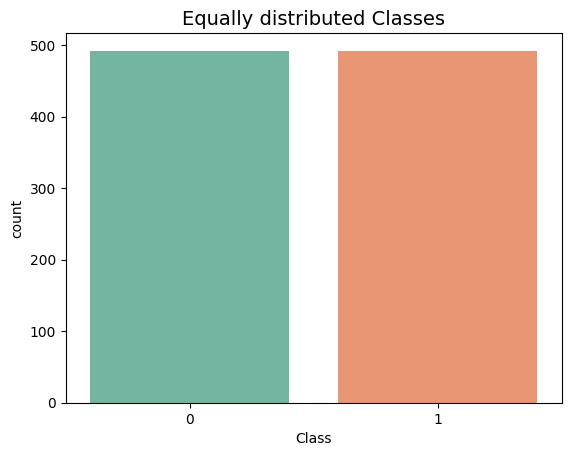

In [ ]:
print('Distribution of the classes in the subsampled dataset')
print(new_card_df['Class'].value_counts()/len(new_card_df))

sns.countplot(x = 'Class', data = new_card_df,  palette='Set2')
plt.title('Equally distributed Classes', fontsize=14)
plt.show()

### Matrice de correlation:

Les matrices de correlation sont essentielles pour comprendre nos donnees. Nous voulons savoir s'il existe des caracteristiques qui influencent fortement si une transaction specifique est frauduleuse. Cependant, il est important que nous utilisions le bon dataframe(sous-echantillon) afin de voir quelles caracteristiques ont une forte correlation positive ou negative par rapport aux transaction frauduleuses.


### resume et explications:
- Les variables V17, V14, V12 et V10 présentent une corrélation négative avec la variable Class.
Cela signifie que plus leurs valeurs diminuent, plus la probabilité qu’une transaction soit frauduleuse augmente.

- Les variables V2, V4, V11 et V19 montrent une corrélation positive avec la variable Class.
Cela indique que plus leurs valeurs sont élevées, plus il est probable qu’une transaction soit frauduleuse.

- Des boxplots permettront de visualiser ces tendances en comparant la distribution de ces variables entre les transactions frauduleuses (Class = 1) et non frauduleuses (Class = 0).

- Note: Nous devons nous assurer d'utiliser le sous-echantillon dans notre matrice de correlation, sinon notre matrice de correlation sera affectee par le fort desequilibre entre nos classes. Cela se produit en raison du grand desequilibre des classes dans le Dataframe original.

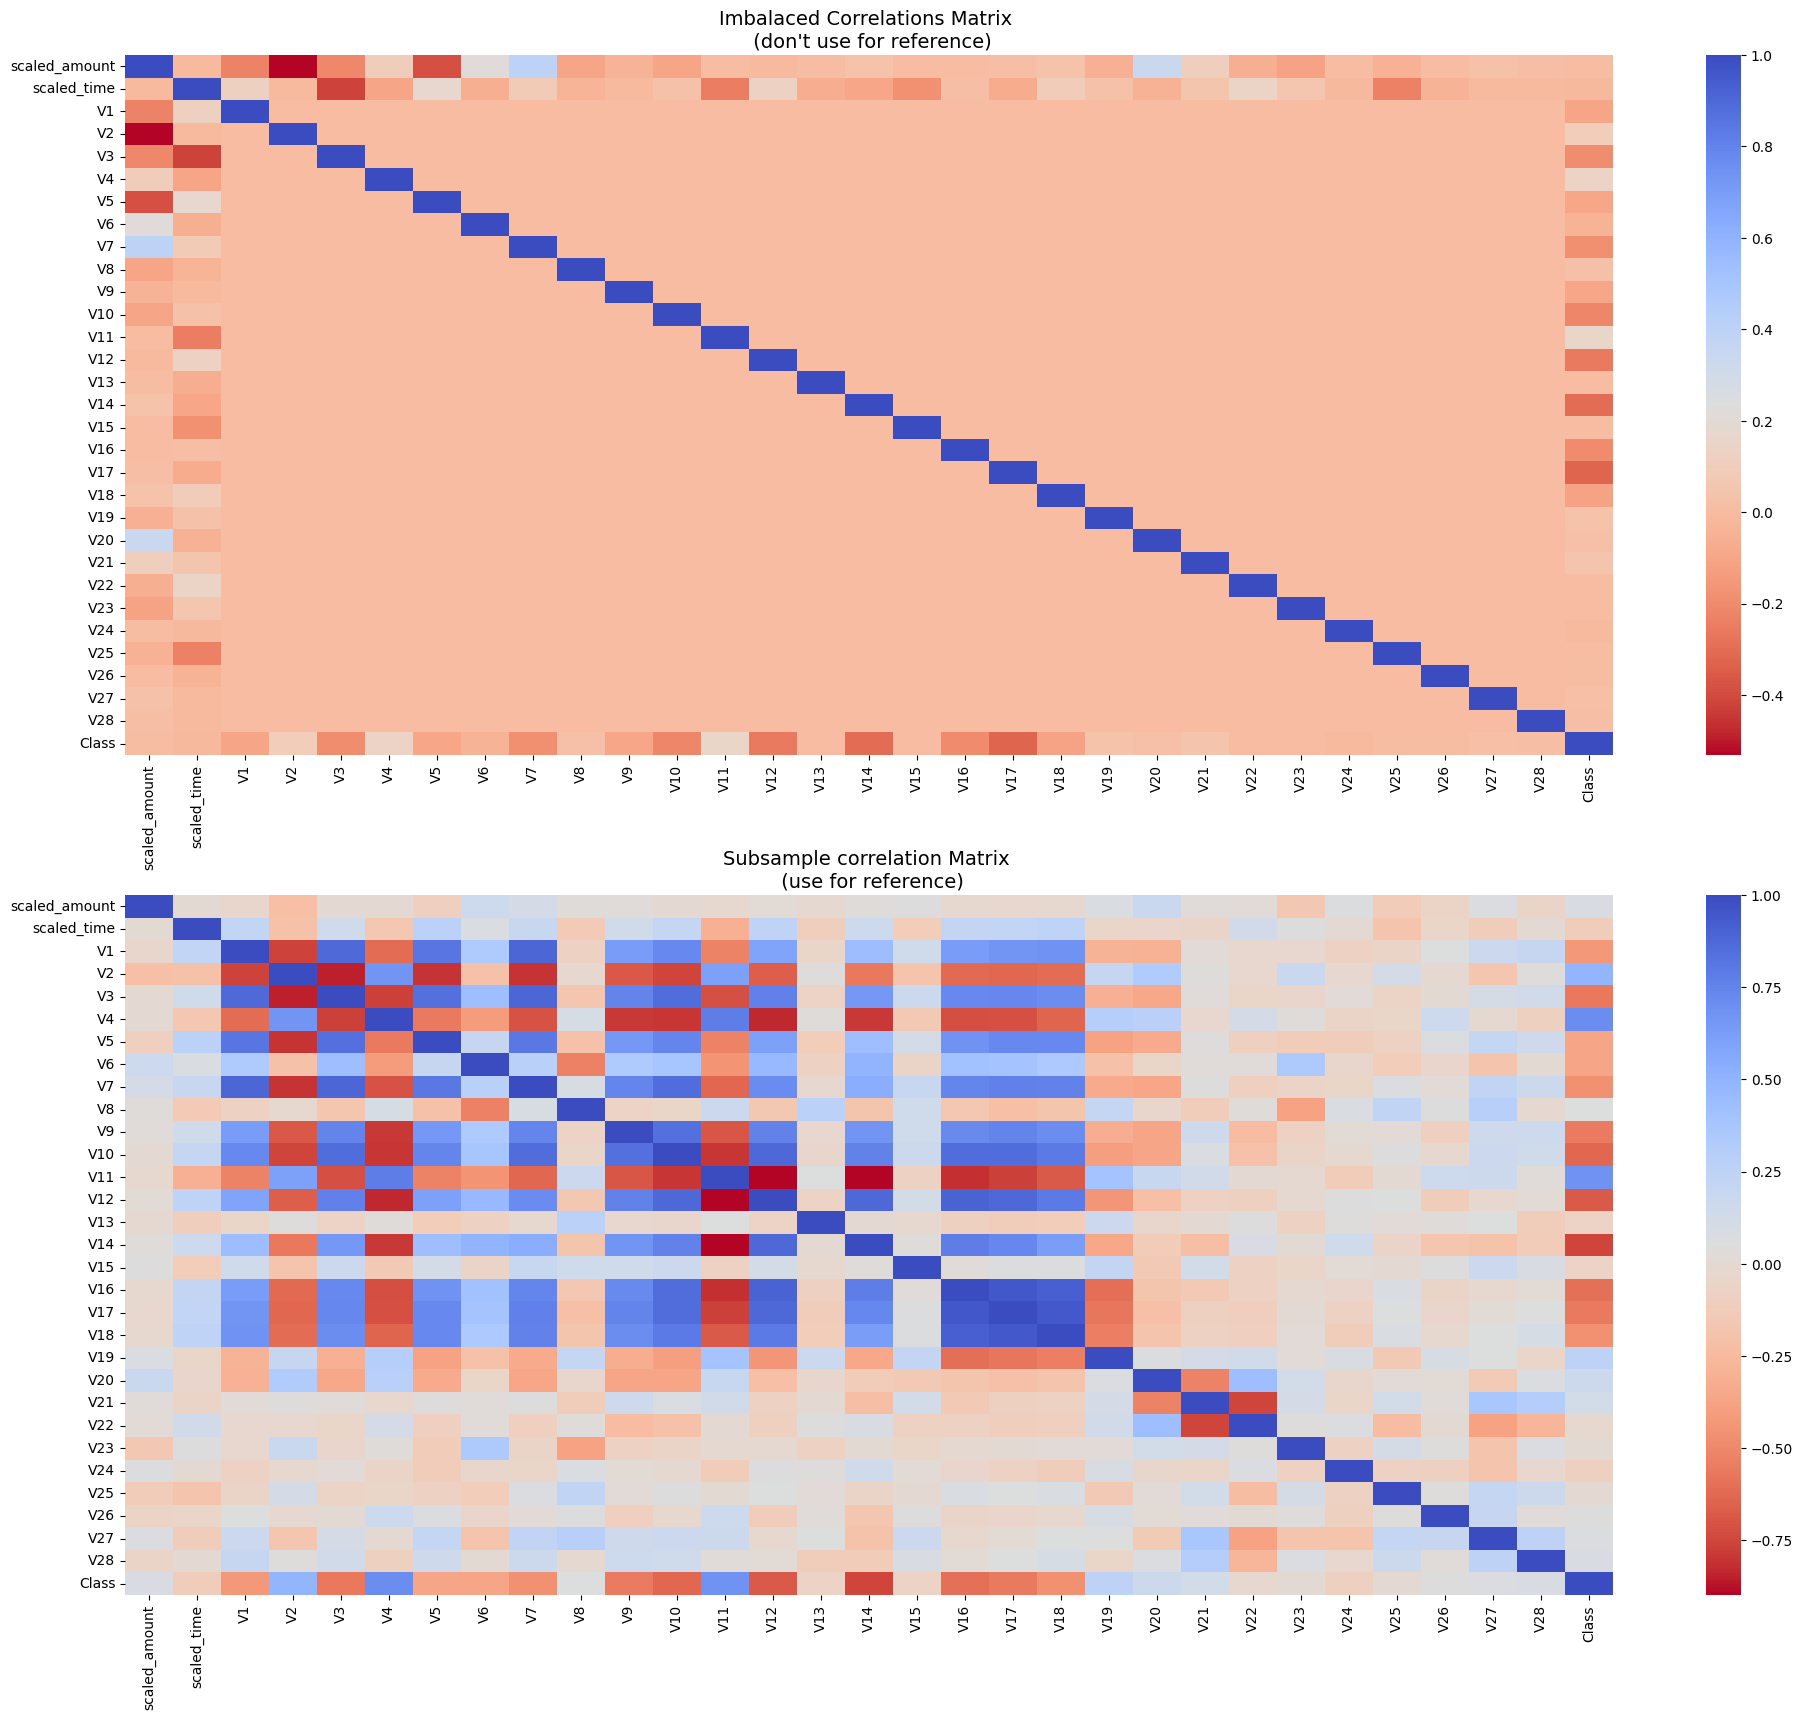

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# entire dataframe
corr = card_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalaced Correlations Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = new_card_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Subsample correlation Matrix \n (use for reference)', fontsize = 14)
plt.show()

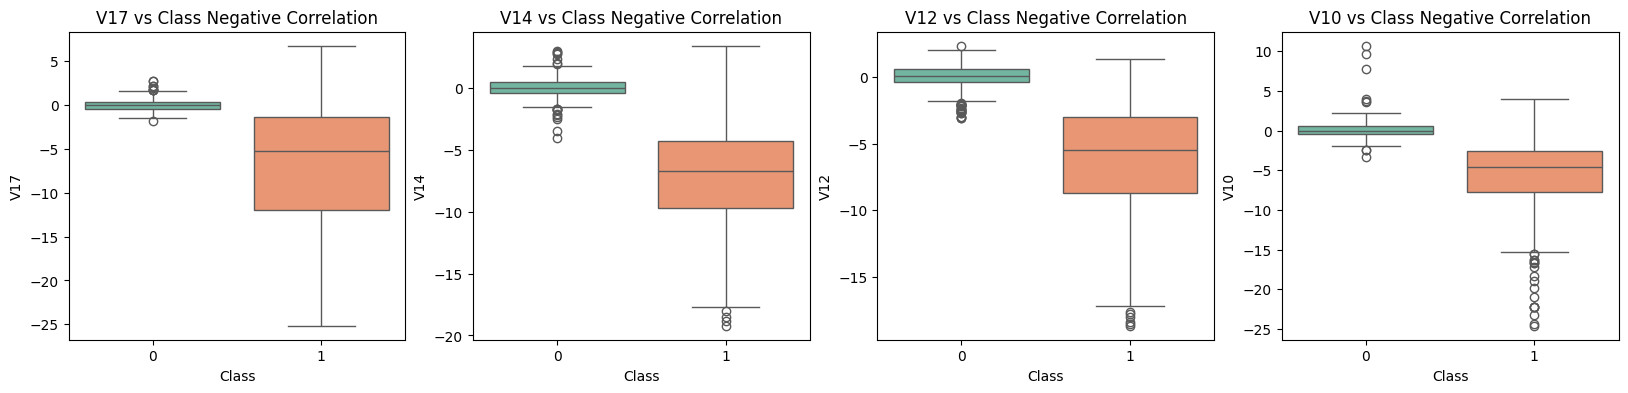

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative correlation with our class (the lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_card_df, palette = 'Set2', ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_card_df, palette='Set2', ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_card_df, palette='Set2', ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V10", data=new_card_df, palette='Set2', ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()


In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative correlation with our class (the lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_card_df, palette = 'Set2', ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_card_df, palette='Set2', ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_card_df, palette='Set2', ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V19", data=new_card_df, palette='Set2', ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

NameError: name 'plt' is not defined

### Detection des anomalies

Notre objectif principal dans cette section est de supprimer les "outliers extremes" des caracteristiques qui ont une forte correlation avec nos classes. Cela aura un impact sur la precision de nos modeles.
#### Methode de l'intervalle interquartile (IQR)

IQR: Nous calculons cela par la difference entre 75e percentile et la 25e percentile. Notre objectif est de creer un seuil au dela du 75e et du 25e percentile, de maniere a ce que si une instance depasse ce seuil, elle soit supprimee. Boxplots: En plus de pouvoir voir facilement les 25e et 75e percentiles, il est aussi facile de reperer les outliers extremes.

#### Compromis de la suppression des outliers:
Nous devons etre prudents quant a la distance a laquelle nous voulons definir le seuil pour supprimer les outliers. Nous determinons ce seuil en multipliant un nombre par l'intervalle interquartile(IQR). Plus ce seuil est eleve, moins d'outliers seront detectes et plus ce seuil est bas, plus il y aura d'outliers detectes.

Le compromis: Plus le seuil est bas, plus d'outliers seront supprimes, cependant, nous voulons nous concentrer davantage sur les outliers extremes plutot que sur les simples outliers. Parceque nous risquons de perdre des informations, ce qui pourrait entrainer une dimunition de la precision de nos modeles

#### RAesume:

- Nous commencons par visualiser la distribution des caracteristiques que nous allons utiliser pour eliminer certains outliers. v14 est la seule caracteristique qui suit une distribution gaussienne par rapport aux caracteristiques v12 et v10.

- Apres avoir decide quel nombre nous allons utiliser pour multiplier l'IQR, nous allons determiner les seuils superieurs et inferieurs en soustrayant (q25 - seuil) pour le seuil extreme inferieur et en ajoutant (q75+ seuil) pour le seuil extreme superieur.

- Enfin nous creeons une suppression conditionnelle, indiquant que si le seuil est depasse dans les deux extremes les instances seront supprimees.

**Note**

Apres avoir applique la reduction des outliers, notre precision a ete amelioree de plus de 3%. Certains outliers peuvent fausser la precision de nos modlees mais il est important de veiller a ne pas perdre trop d'informations, si non notre modele risque de souffrir de sous-apprentissage

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 6))

v14_fraud_dist = new_card_df['V14'].loc[new_card_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax = ax1, fit = norm, color = 'r')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize = 14)


v12_fraud_dist = new_card_df['V12'].loc[new_card_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax = ax2, fit = norm, color = 'grey')
ax1.set_title('V12 Distribution \n (Fraud Transactions)', fontsize = 14)

v10_fraud_dist = new_card_df['V10'].loc[new_card_df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax = ax3, fit = norm, color = 'purple')
ax1.set_title('V12 Distribution \n (Fraud Transactions)', fontsize = 14)


plt.show()

In [ ]:
## v14 removing outliers (highest Negative correlated with Labels)
v14_fraud = new_card_df['V14'].loc[new_card_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('quartile 25 {} | quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('Interquartile range: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('v14 Lower: {}'.format(v14_lower))
print('v14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature v14 outliers for fraud cases {}'.format(len(outliers)))
print('v10 outliers: {}'.format(outliers))

new_card_df = new_card_df.drop( new_card_df[(new_card_df['v14'] > v14_upper) | (new_card_df['v14'] < v14_lower)].index)
print("----" * 44)

# v12 removing outliers from fraud transactions

v12_fraud = new_card_df['V12'].loc[new_card_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('v12 Lower: {}'.format(v12_lower))
print('v12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('v12 outliers: {}'.format(outliers))
print('Feature v12 outliers for fraud cases {}'.format(len(outliers)))
print('Number of instances after outliers removal: {}'.format(len(new_card_df)))
print("-----" * 44)

# removing outliers v10 feature
v10_fraud = new_card_df['V10'].loc[new_card_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('v10 Lower: {}'.format(v10_lower))
print('v10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('v10 outliers: {}'.format(outliers))
print('Feature v10 outliers for fraud cases {}'.format(len(outliers)))
print('Number of instances after outliers removal: {}'.format(len(new_card_df)))


In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 6))

colors = ['#3498db', '#e74c3c']
# boxplots with outliers removed
# feature v14
sns.boxplot(x="Class", y="V14", data=new_card_df, ax=ax1, palette=colors)
ax1.set_title("v14 feature \n reduction of outliers", fontsize=14)
ax1.annotate('fewer extreme \n outliers', xy=(0.98, -17.5), xylext=(0, -12),
             arrowprops=dict(facecolor='black'), fontsize=14)

# feature v12
sns.boxplot(x="Class", y="V12", data=new_card_df, ax=ax2, palette=colors)
ax1.set_title("v12 feature \n reduction of outliers", fontsize=14)
ax1.annotate('fewer extreme \n outliers', xy=(0.98, -17.3), xylext=(0, -12),
             arrowprops=dict(facecolor='black'), fontsize=14)

# feature v10
sns.boxplot(x="Class", y="V10", data=new_card_df, ax=ax3, palette=colors)
ax1.set_title("v10 feature \n reduction of outliers", fontsize=14)
ax1.annotate('fewer extreme \n outliers', xy=(0.95, -16.5), xylext=(0, -12),
             arrowprops=dict(facecolor='black'), fontsize=14)

plt.show()



In [ ]:
# new_card_df is from the random undersample data (fewer instances)
X=new_card_df.drop('Class', axis=1)
y=new_card_df['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state = 42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s", format(t1-t0))

# PCA implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state = 42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s", format(t1-t0))

# TruncatedSVD
t0 = time.time()
X_reduced_tsvd = TruncatedSVD(n_components=2, algorithm='randomized',random_state = 42).fit_transform(X.values)
t1 = time.time()
print("TruncatedSVD took {:.2} s", format(t1-t0))


In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (24, 6))
# Labels =['No Fraud','Fraud]
f.suptitle('Clusters using Dimensionality Reduction', fontsize = 14)

blue_patch = mpatches.Patch(color='#3498db', label='No Fraud')
red_patch = mpatches.Patch(color='#e74c3c', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize = 14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize = 14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])


# TruncatedSVD scatter plot
ax3.scatter(X_reduced_tsvd[:,0], X_reduced_tsvd[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_tsvd[:,0], X_reduced_tsvd[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize = 14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()



**classificateurs(Sous-echantillonnage)**:
Dans cette section nous allons entrainer 4 types de classificateurs et determiner lequel sera le plus efficacepour detecter les transactions frauduleuses. Avant cela, nous devons diviser nos donnees en ensembles d'entrainements et de test et separer les caracteristiques des etiquettes.

- Le classificateur de regression Logistique est le plus precis que les 3 autres classificateurs dans la plupart des cas. ( Nous analyserons la regression logistique plus en detail)
- GridsearchCV est utilise pour determiner les parametres qui donnent le meilleur score predictif pour les classificateurs.
- La regression logistique a le meilleur score de la caracteristique de reception operatoire (ROC) ce qui signifie qu'elle separe assez precisement les transactions frauduleuses et non frauduleuses.

Courbes d'apprentissage:
plus l'ecart entre le score d'entrainement et le score de validation est grand, plus il est probable que le modele fait du surapprentissage(variance elevee). Si le sccre est faible a la fois dans les ensembles d'entrainements et de validation croisee, cela indique que notre modele fait du surapprentissage (biais eleve). Le classificateur de regression logistique montre le meillleur score a la fois dans les ensembles d entrainements et de validation croisee

In [ ]:
# undersampling before cross validating (prone to ovefit)
X = new_card_df.drop('Class', axis=1)
y = new_card_df['Class']

In [ ]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# this is explicicitly used for undersampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# turn the values intoan array for feeding the classification algorithms

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:

classifiers = {


               "Logistic Regression": LogisticRegression(),
               "KNearest": KNeighborsClassifier(),
               "Support Vector Classifier": SVC(),
               "Decision Tree": DecisionTreeClassifier()

}

